<a href="https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/process/masstransferMeOH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Calculation of mass transfer and hydrate inhibition of a wet gas by injection of methanol
#@markdown Demonstration of mass transfer calculation using the NeqSim software in Python
#@markdown <br><br>This document is part of the module ["Introduction to Gas Processing using NeqSim in Colab"](https://colab.research.google.com/github/EvenSol/NeqSim-Colab/blob/master/notebooks/examples_of_NeqSim_in_Colab.ipynb#scrollTo=_eRtkQnHpL70).
%%capture
!pip install neqsim
import neqsim
from neqsim.thermo.thermoTools import *
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from neqsim.thermo import fluid, fluid_df
import pandas as pd
from neqsim.process import gasscrubber, clearProcess, run,nequnit, phasemixer, splitter, clearProcess, stream, valve, separator, compressor, runProcess, viewProcess, heater,saturator, mixer

plt.style.use('classic')
%matplotlib inline

#Mass transfer calculations
Model for mass transfer calculation in NeqSim based on Solbraa (2002):

https://ntnuopen.ntnu.no/ntnu-xmlui/handle/11250/231326

In the following calculations we assume a water saturated gas the is mixed with pure liquid methanol. These phases are not in equiibrium when they enter the pipeline. When the gas and methanol liquid comes in contact in the pipeline, methanol will vaporize into the gas, and water (and other comonents from the gas) will be absorbed into the liquid methanol. The focus of the following calculations will be to evaluate the mass transfer as function of contanct length with gas and methanol. It also evaluates the hydrate temperature of the gas leanving the pipe section.

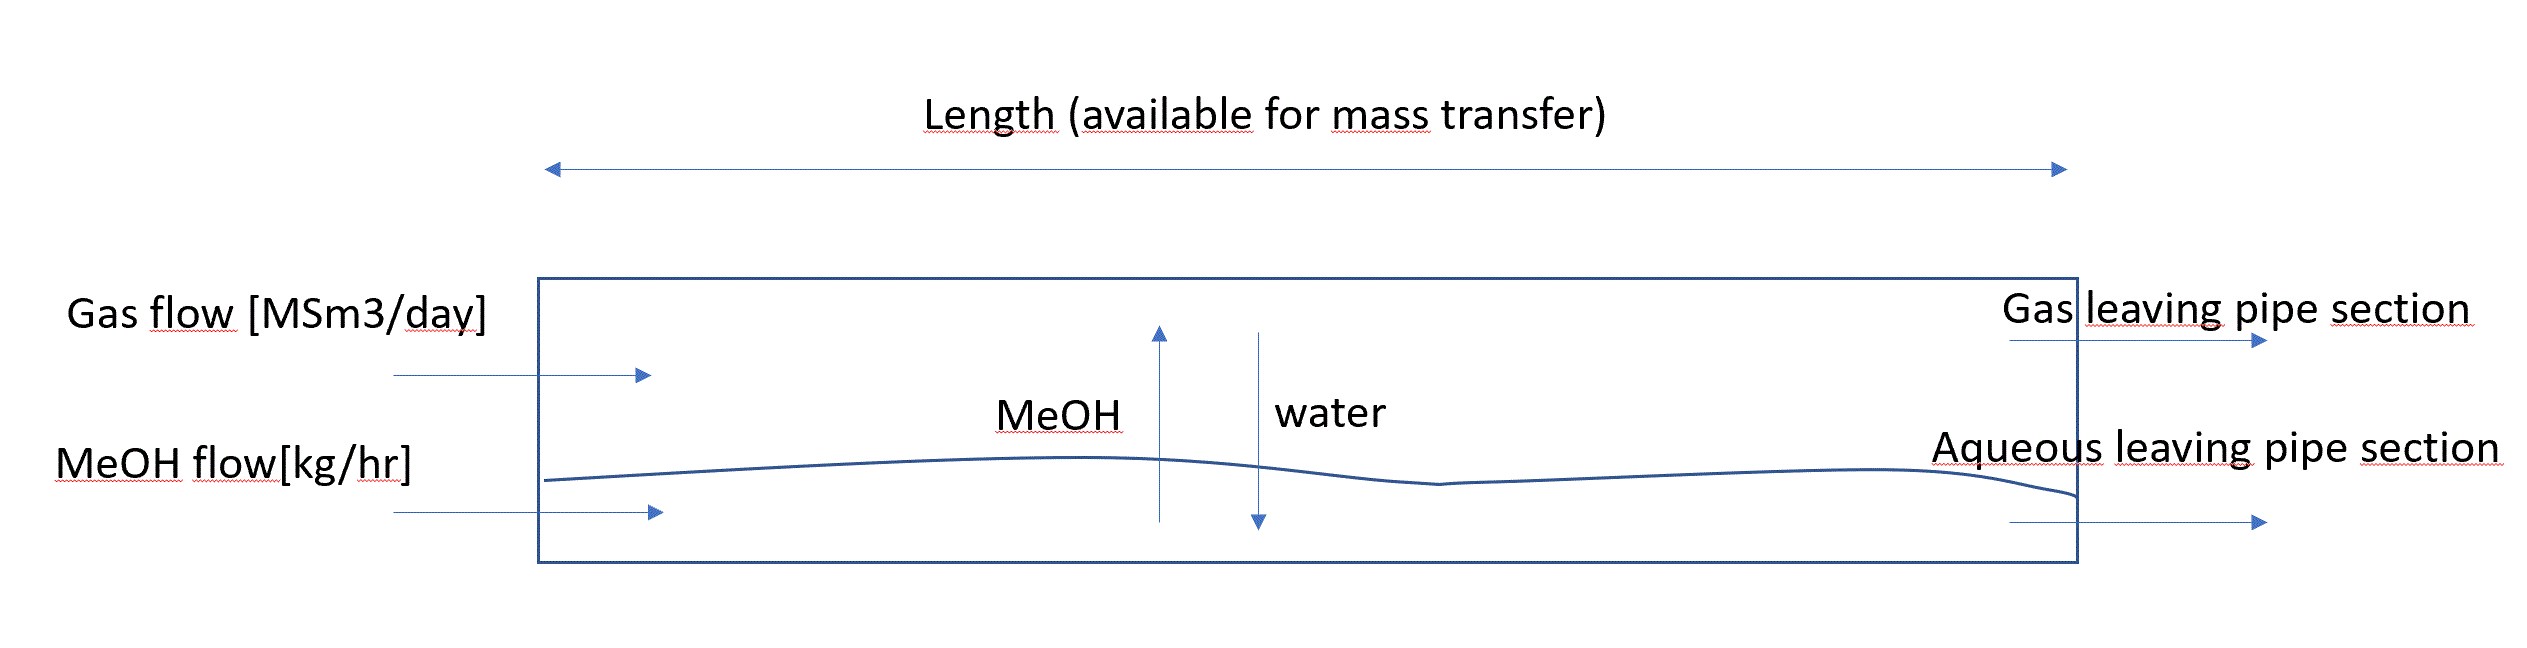

**The parameters for the model are:**

Temperature and pressure of the pipe (mass transfer calculated at constant temperature and pressure).

Length and diameter of pipe where gas and liquid will be in contact and mass transfer can occur.

Flow rate of the gas in MSm3/day, flow rate of methanol (kg/hr).





#Calculation of compostion of aqueous phase and gas leaving pipe section
In the following script we will simulate the composition of the gas leaving pipe section at a given pipe lengt.

In [2]:
# Input parameters
pressure = 52.21 # bara
temperature = 15.2 #C
gasFlow = 1.23 #MSm3/day
methanolFlow = 60.23 # kg/day

pipelength = 24.0 #meter
pipeInnerDiameter = 0.5 #meter

# Create a gas-condensate fluid
feedgas = {'ComponentName':  ["nitrogen","CO2","methane", "ethane" , "propane", "i-butane", "n-butane", "water", "methanol"], 
        'MolarComposition[-]':  [0.01, 0.01, 0.8, 0.06, 0.01,0.005,0.005, 0.0, 0.0]
} 

naturalgasFluid = fluid_df(pd.DataFrame(feedgas)).setModel("CPAs-SRK-EOS-statoil")
naturalgasFluid.setTotalFlowRate(gasFlow, "MSm3/day")
naturalgasFluid.setTemperature(temperature, "C")
naturalgasFluid.setPressure(pressure, "bara")

# Create a liquid methanol fluid
feedMeOH = {'ComponentName':  ["nitrogen","CO2","methane", "ethane" , "propane", "i-butane", "n-butane", "water", "methanol"], 
        'MolarComposition[-]':  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,1.0]
} 
meOHFluid = fluid_df(pd.DataFrame(feedMeOH) ).setModel("CPAs-SRK-EOS-statoil")
meOHFluid.setTotalFlowRate(methanolFlow, "kg/hr");
meOHFluid.setTemperature(temperature, "C");
meOHFluid.setPressure(pressure, "bara");

clearProcess()
dryinjectiongas = stream(naturalgasFluid)
MeOHFeed = stream(meOHFluid)
watersaturator = saturator(dryinjectiongas)
waterSaturatedFeedGas = stream(watersaturator.getOutStream())

mainMixer = phasemixer("gas MeOH mixer")
mainMixer.addStream(waterSaturatedFeedGas)
mainMixer.addStream(MeOHFeed)
		
pipeline = nequnit(mainMixer.getOutStream(), equipment="pipeline", flowpattern="stratified")
pipeline.setLength(pipelength)
pipeline.setID(pipeInnerDiameter)

scrubber = gasscrubber(pipeline.getOutStream())
gasFromScrubber = stream(scrubber.getGasOutStream())
aqueousFromScrubber = stream(scrubber.getLiquidOutStream())
run()
print('Composition of gas leaving pipe section after ', pipelength, ' meter')
printFrame(gasFromScrubber.getFluid())
print('Composition of aqueous phase leaving pipe section after ', pipelength, ' meter')
printFrame(aqueousFromScrubber.getFluid())



Composition of gas leaving pipe section after  24.0  meter
                          total                   gas                       
           nitrogen  1.11048E-2            1.11048E-2        [mole fraction]
                CO2  1.11021E-2            1.11021E-2        [mole fraction]
            methane  8.88362E-1            8.88362E-1        [mole fraction]
             ethane  6.66209E-2            6.66209E-2        [mole fraction]
            propane  1.11016E-2            1.11016E-2        [mole fraction]
           i-butane  5.54944E-3            5.54944E-3        [mole fraction]
           n-butane  5.54971E-3            5.54971E-3        [mole fraction]
              water  3.72929E-4            3.72929E-4        [mole fraction]
           methanol  2.36467E-4            2.36467E-4        [mole fraction]
                                                                            
            Density                         4.52102E1               [kg/m^3]
      PhaseFracti

# Calculation of hydrate equilibrium temperature of gas leaving pipe section
In the following script we will simulate the composition of the gas  leaving pipe section as well as hydrate equilibrium temperature of this gas as function of pipe length.

Text(0.5, 1.0, 'Hydrate eq.temperature of gas leaving pipe section')

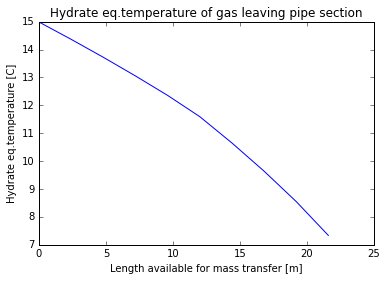

In [3]:
maxpipelength = 24.0

def hydtemps(length):
    pipeline.setLength(length)
    run();
    return gasFromScrubber.getHydrateEquilibriumTemperature()-273.15

length = np.arange(0.01, maxpipelength, (maxpipelength)/10.0)
hydtem = [hydtemps(length2) for length2 in length]

plt.figure()
plt.plot(length, hydtem)
plt.xlabel('Length available for mass transfer [m]')
plt.ylabel('Hydrate eq.temperature [C]')
plt.title('Hydrate eq.temperature of gas leaving pipe section')